In [6]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import numpy as np
import sep
import matplotlib.pyplot as plt

from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

In [3]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)
    
    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

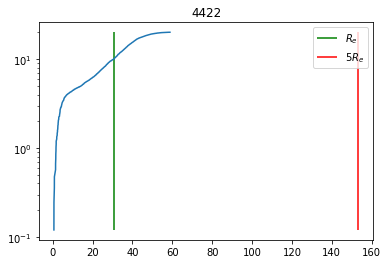

Converged 1/1=1.0


In [116]:
spheroids = get_random_spheroids(num=1)
num_converged, total = 0, len(spheroids)
found_res = []

for img, segmap, img_id in spheroids:
    src_map = segmap==img_id
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map,bw=10,bh=10)
    img_sub = img-bkg
    
    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))
    
    rs = rs.flatten()
    fs = img.flatten()
    fs_sub = img_sub.flatten()

    sorted_rs = np.argsort(rs)
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    fs_sub = fs_sub[sorted_rs]
    
    fs[fs<0] = 0
    fs_sub[fs_sub<0] = 0
    
    
    fs_int = np.cumsum(fs)
    fs_sub_int = np.cumsum(fs_sub)
    
    re = 0.1 * rs.max()
    is_converged = False
    tolerance = 1e-3
    max_attempts = 1000
    count = 0
    
    while (count < max_attempts):
        int_limit = 5 * re
        interp_re_int = np.interp(re, rs, fs_sub_int)
        interp_int_limit = np.interp(int_limit, rs, fs_sub_int)
            
        if (interp_re_int/interp_int_limit-0.5 > tolerance):
            re = re**0.995
        elif (interp_re_int/interp_int_limit-0.5 < -tolerance):
            re = re**1.01
        else:
            is_converged = True
    
        if is_converged:
            found_res.append(re)
            num_converged += 1
            break
    
        count += 1
    if True:
        plt.figure()
        plt.title(img_id)
        plt.semilogy(rs, fs_sub_int)
        plt.vlines([re], fs_sub_int.min(), fs_sub_int.max(), color='g', label='$R_e$')
        plt.vlines([int_limit], fs_sub_int.min(), fs_sub_int.max(), color='r', label="$5R_e$")
        plt.legend()
        plt.show()
        
        
    if not is_converged:
        print(f'{img_id} did not converge')

print(f'Converged {num_converged}/{total}={num_converged/total}')    

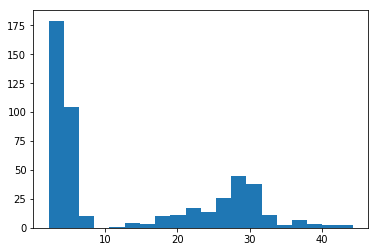

In [104]:
#hist_res = found_res
plt.hist(hist_res, bins=20)
plt.show()
